# University Certificate in Artificial Intelligence (Hands on AI, Third Challenge, 2022-2023, UMONS)
# Introduction to time series analysis and forecasting




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]


## White noise time series



- Generate a time series with 500 observations from a white noise process with zero mean and unit standard deviation.



In [2]:
# Hint: use np.random.normal

white_noise = np.random.normal(loc=0, scale=1, size=500)


- Plot the generated tiime series.


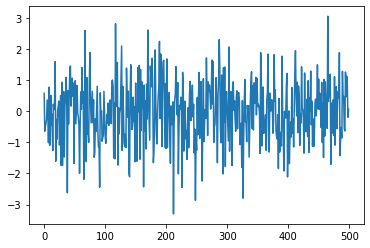

In [3]:
plt.plot(white_noise)


- Compute and plot the ACF for 50 lags. Did you expect to see such results? Why?

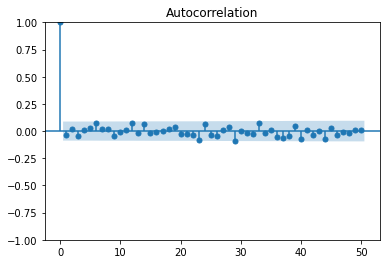

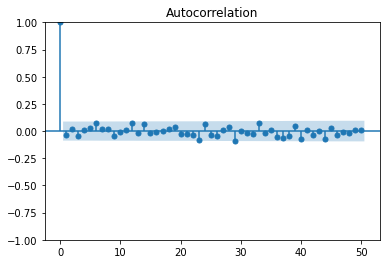

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
# Hint: use plot_acf

plot_acf(white_noise, lags=50)


* Perform a Ljung-Box test for the first ten lags.

In [5]:
from statsmodels.stats.diagnostic import acorr_ljungbox
# Hint: use acorr_ljungbox

acorr_ljungbox(white_noise, lags = 10)

,lb_stat,lb_pvalue
1,0.739594,0.389791
2,1.002175,0.605871
3,1.916637,0.589888
4,1.937055,0.747335
5,2.436100,0.786086
6,5.071537,0.534671
7,5.200064,0.635563
8,5.479035,0.705362
9,6.412856,0.697992
10,6.491946,0.772379


## Real-world time series

In [6]:

# Read the data file
DF = pd.read_csv("../data/public/train.csv", parse_dates = True)


DF['Day'] =  pd.to_datetime(DF['Day'], format='%Y-%m-%d')
DF.set_index("Day", inplace=True)
DF = DF.asfreq("D")
print(DF)


                 s001       s002       s003       s004       s005       s006  \
Day                                                                            
1996-03-18  13.407029  11.550454   5.640590  13.180272   9.778912   9.240363   
1996-03-19  14.725057  13.591270  14.399093   8.446712  10.813492  11.635488   
1996-03-20  20.564059  15.036848  24.418934  19.515306  21.612812  12.103175   
1996-03-21  34.708050  21.570295  28.784014  28.883220  38.520408  21.414399   
1996-03-22  26.629819  19.444444  20.620748  19.472789  24.744898  24.674036   
...               ...        ...        ...        ...        ...        ...   
1998-03-18  30.087868  18.750000        NaN  27.054989  25.283447  23.767007   
1998-03-19  54.138322  29.676871  21.683673  36.848073  41.723356  30.881519   
1998-03-20  53.500567  30.725624  35.586735  29.946145  33.475057  37.074830   
1998-03-21  39.696712  16.737528  18.636621  20.082200  16.198980   4.067460   
1998-03-22  29.705215  12.046485  13.095

In [7]:
print(DF.shape)


(735, 111)


- Compute the number of missing values per series.


In [8]:
# Hint: use isna()

print(DF.isna().sum().sort_values(ascending=False))

s095    29
s064    28
s016    26
s078    23
s051    23
        ..
s027     9
s108     9
s010     9
s040     8
s032     8
Length: 111, dtype: int64


- Replace the missing values with the method of your choice.


In [9]:
# Hint: you can use fillna()
DF.fillna(method = "backfill", inplace = True)
print(DF.isna().sum().sort_values(ascending=False))


s001    0
s071    0
s082    0
s081    0
s080    0
       ..
s034    0
s033    0
s032    0
s031    0
s111    0
Length: 111, dtype: int64


- Select one series (among "s001", "s002", ..., "s111") and plot it.


<AxesSubplot: xlabel='Day'>

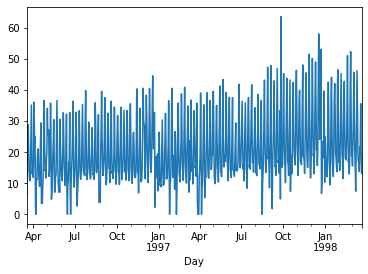

In [10]:
# Select one series (among "s001", "s002", ..., "s111") and plot it
my_series = "s003"
DF[my_series].plot()

In [11]:
# Extract calendar variables from dates (useful for seasonal plots)
DF["d"] = DF.index.day.to_numpy()
DF["m"] = DF.index.month.to_numpy()
DF["y"] = DF.index.year.to_numpy()
DF["w"] = DF.index.weekday.to_numpy()
DF["wy"] = DF.index.isocalendar().week.to_numpy()
DF.head()

,s001,s002,s003,s004,s005,s006,s007,s008,s009,s010,...,s107,s108,s109,s110,s111,d,m,y,w,wy
Day,,,,,,,,,,,,,,,,,,,,,
1996-03-18,13.407029,11.550454,5.640590,13.180272,9.778912,9.240363,14.937642,2.891156,7.341270,10.289116,...,8.857710,9.297052,10.416667,11.635488,8.337717,18,3,1996,0,12
1996-03-19,14.725057,13.591270,14.399093,8.446712,10.813492,11.635488,16.284014,12.358277,9.155329,12.712585,...,11.380385,12.429138,14.923469,10.586735,9.876381,19,3,1996,1,12
1996-03-20,20.564059,15.036848,24.418934,19.515306,21.612812,12.103175,16.666667,16.383220,10.586735,14.441610,...,11.777211,13.251134,25.864512,12.570862,16.320358,20,3,1996,2,12
1996-03-21,34.708050,21.570295,28.784014,28.883220,38.520408,21.414399,23.568594,30.158730,12.500000,19.401927,...,18.820862,24.815760,37.996032,17.517007,22.553919,21,3,1996,3,12
1996-03-22,26.629819,19.444444,20.620748,19.472789,24.744898,24.674036,26.303855,31.179138,7.157029,21.541950,...,24.305556,19.231859,33.290816,24.291383,18.095739,22,3,1996,4,12


- Generate a seasonal plot with the day of the week in the x-axis.

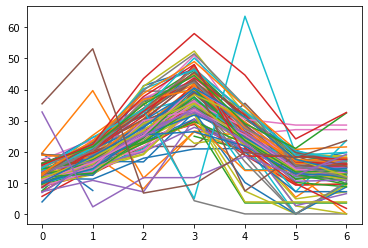

In [12]:
# Seasonal plots (Day of the week)
# Hint: You could generate a data frame with the weekly series and plot it

patterns_day_week = DF[[my_series, "wy", "y", "w"]].pivot_table(index=['w'], columns=['wy', 'y'])
plt.plot(patterns_day_week)




- Plot a boxplot for each day of the week.

<AxesSubplot: >

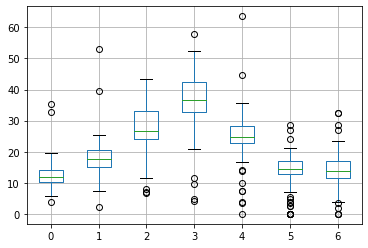

In [13]:
patterns_day_week.transpose().boxplot()

- Generate a seasonal plot with the day of the month in the x-axis.

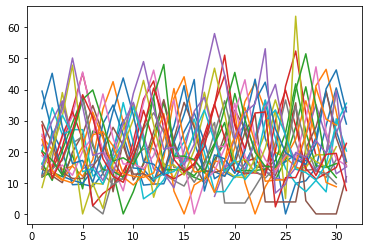

In [14]:
# Seasonal plots (Day of the month)
patterns_day_month = DF[[my_series, "d", "m", "y"]].pivot_table(index=['d'], columns=['m', 'y'])
plt.plot(patterns_day_month)
plt.show()



<AxesSubplot: >

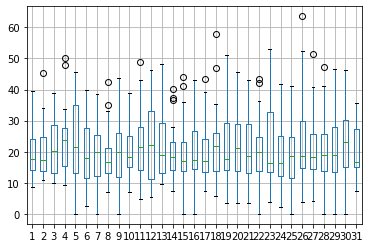

In [15]:
patterns_day_month.transpose().boxplot()

- Produce lagged scatterplots for lags 1, 3 and 7. What do you observe? Add the diagonal for a better visualization.

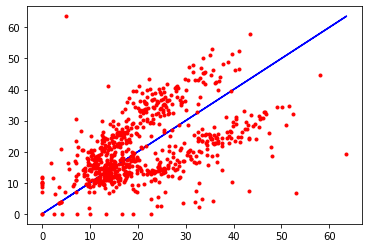

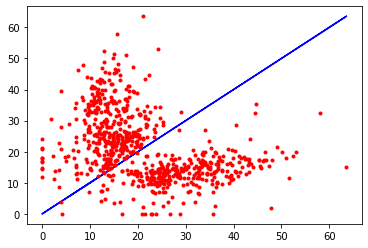

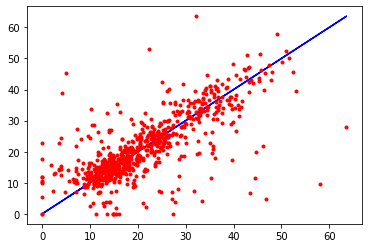

In [16]:
# Lag plot

def lag_plot(series, lag = -1, ls = 'r.'):
    y_lag = series.shift(lag)
    plt.plot(series, series, 'b-')
    plt.plot(y_lag, series, ls)
    plt.show()

lag_plot(DF[my_series], lag = 1)
lag_plot(DF[my_series], lag = 3)
lag_plot(DF[my_series], lag = 7)



## Autocorrelation
* Plot the autocorrelation function (ACF) for the first 20 lags, and interpret the results. 



<AxesSubplot: xlabel='Day'>

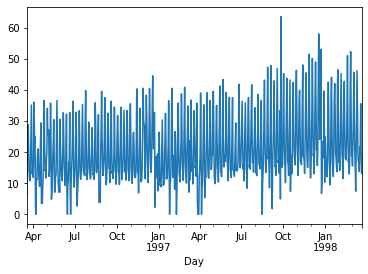

In [17]:
DF[my_series].plot()


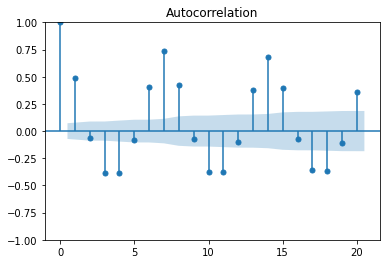

In [18]:
plot_acf(DF[my_series], lags= 20, alpha=0.05)
plt.show()


* Recompute the ACF after applying a seasonal difference. 


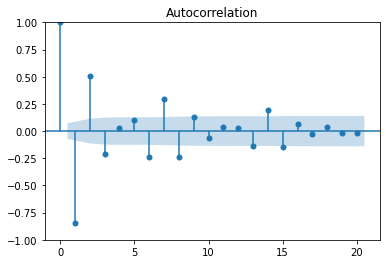

In [19]:
# Hint: use np.diff
plot_acf(np.diff(DF[my_series], 7), lags= 20, alpha=0.05)
plt.show()

- Compute and print the ACF values for the first 20 lags.

In [20]:
from statsmodels.graphics.tsaplots import acf
# Hint: use acf
print(acf(DF[my_series]))

[ 1.          0.4893605  -0.06717867 -0.38719569 -0.38649077 -0.08597054
  0.4071255   0.73486854  0.42355609 -0.07726267 -0.37910357 -0.37321457
 -0.09823404  0.3746983   0.67713287  0.39862382 -0.07622718 -0.35691587
 -0.370129   -0.11052039  0.36069308  0.65341858  0.41210281 -0.0910925
 -0.36813055 -0.37769106 -0.11158289  0.35682884  0.64223022]


* Perform a Ljung-Box test for the series.

In [21]:
acorr_ljungbox(DF[my_series], period = 7)


,lb_stat,lb_pvalue
1,176.732570,2.505349e-40
2,180.067708,7.921257e-40
3,291.011951,8.768756e-63
4,401.703816,1.191674e-85
5,407.188243,8.373441e-86
6,530.352278,2.425384e-111
7,932.182650,5.383213e-197
8,1065.855210,9.052786e-225
9,1070.309287,1.180780e-224
10,1177.691553,9.338535e-247


## Transformations

* Apply a Box-Cox transformation with $\lambda = 0.5$, $\lambda = 0.3$ and $\lambda = 0$. Plot the transformed series.

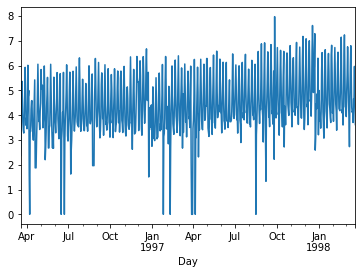

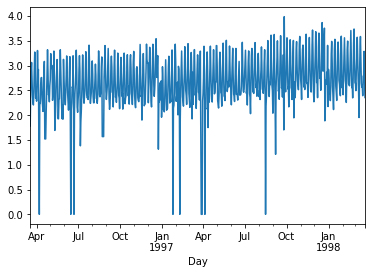

<AxesSubplot: xlabel='Day'>

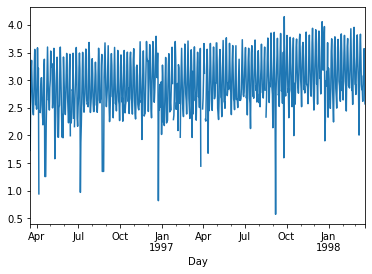

In [22]:
DF[my_series].transform(lambda x: x ** 0.5).plot()
plt.show()
DF[my_series].transform(lambda x: x ** 0.333).plot()
plt.show()
DF[my_series].transform(lambda x: np.log(x)).plot()


- Find the best value of $\lambda$ in the Box-Cox transformation, and plot the transformed series.

0.5684378511649728


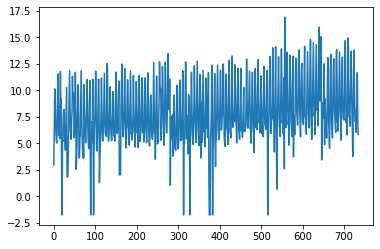

In [23]:
from scipy.stats import boxcox
eps = 0.0001
x = DF[my_series] + eps
# Hint: use boxcox on the x variable.

x, opt_lambda = boxcox(x)
print(opt_lambda)
plt.plot(x)

## Time series decomposition 


* Decompose the time series into trend, seasonal and remainder components. Plot the different component. Does it help you to understand the data?

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Hint: use seasonal_decompose

result = seasonal_decompose(DF[my_series])


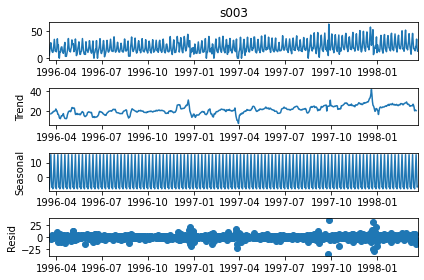

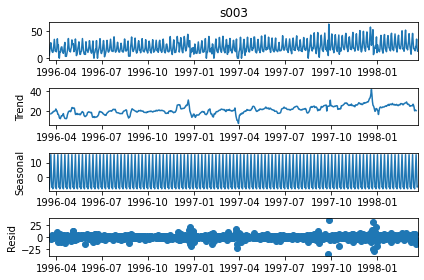

In [25]:
result.plot()

* Use the STL decomposition algorithm to decompose the series into trend, seasonal and remainder components.

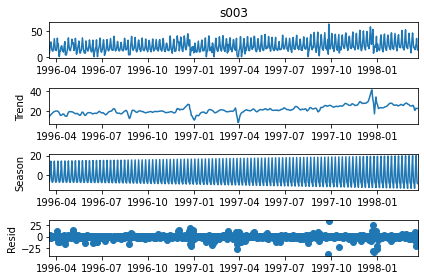

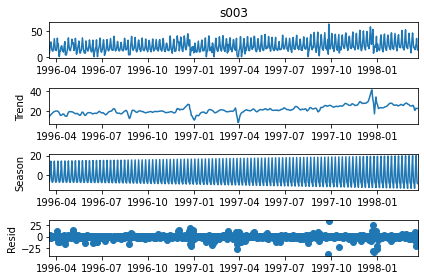

In [26]:
from statsmodels.tsa.seasonal import STL
# Hint: Use STL with period = 7

stl = STL(DF[my_series], period = 7, robust = True, seasonal = 7*30 + 1)
result = stl.fit()
result.plot()






- Plot the deseasonalized series, i.e. $z_t = y_t - s_t$.

<AxesSubplot: xlabel='Day'>

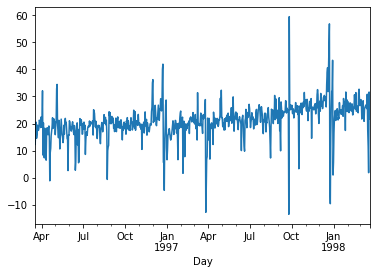

In [27]:
# Deaseasonlized data
deaseasonlized_data = result.trend + result.resid
deaseasonlized_data.plot()




## Forecasting

Split the time series in a training and a test set where the test set is composed of the last 21 observations.

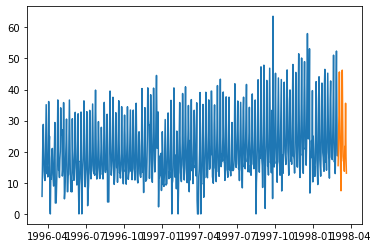

In [28]:
series = DF[my_series]

n_test = 21
series_train = series[:-n_test]
series_test = series[-n_test:]

plt.plot(series_train)
plt.plot(series_test)

* Compute the in-sample one-step ahead predictions for simple forecasting methods (mean, naive, and sesonal naive).

In [29]:
## Mean forecasts

fit_mean = [series_train[:i].mean() for i in range(1, len(series_train)) ]
resid_mean = series_train.values[1:] - fit_mean

In [30]:

## Naive forecasts

fit_naive = [series_train[i-1] for i in range(1, len(series_train)) ]
resid_naive = series_train.values[1:] - fit_naive

In [31]:

## Seasonal naive forecasts
# For the first week, you can compute a naive forecast (non-seasonal)

fit_snaive = [series_train[i-7] for i in range(7, len(series_train)) ]
fit_snaive = fit_naive[:6] + fit_snaive
resid_snaive = series_train.values[1:] - fit_snaive

* Plot a histogram of residuals for the three mthods.

<AxesSubplot: ylabel='Frequency'>

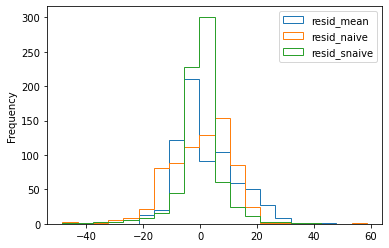

In [32]:
# 
resid = pd.DataFrame({'resid_mean': resid_mean, 'resid_naive': resid_naive, 'resid_snaive': resid_snaive})
resid.plot.hist( bins = 20, histtype = "step")

* Compute the bias for each method. Which method has a higher bias?


In [33]:
#
resid.mean()

resid_mean      2.306999
resid_naive     0.018327
resid_snaive    0.116221
dtype: float64

* Compute the mean squared error (MSE).


In [34]:
#
(resid**2).mean()

resid_mean      111.944144
resid_naive     113.336511
resid_snaive     58.154758
dtype: float64

* Plot the ACF for the first 20 lags. Which method has a better fit and why?


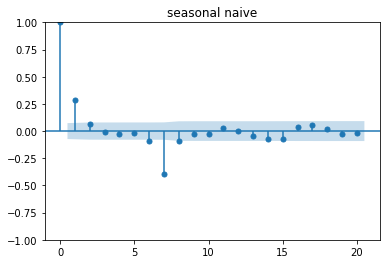

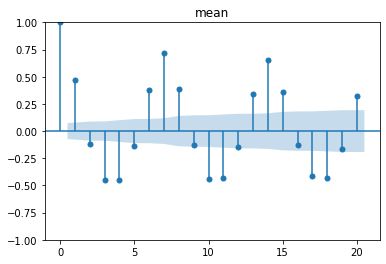

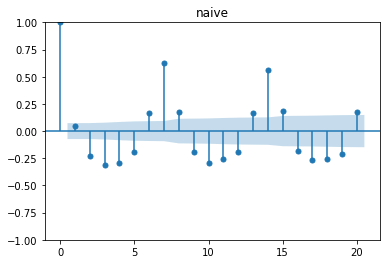

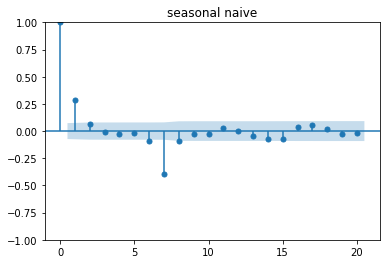

In [35]:
# Plot the ACF for the first 20 lags. Which method has a better fit and why?
plot_acf(resid_mean, lags= 20, alpha=0.05, title = "mean")
plot_acf(resid_naive, lags= 20, alpha=0.05, title = "naive")
plot_acf(resid_snaive, lags= 20, alpha=0.05, title = "seasonal naive")

* For each method, plot the predictions and the true in-sample values.


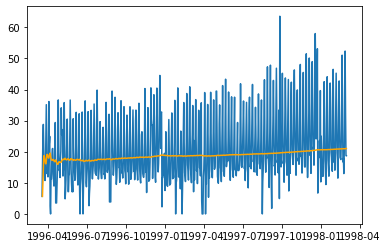

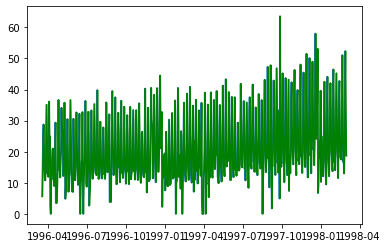

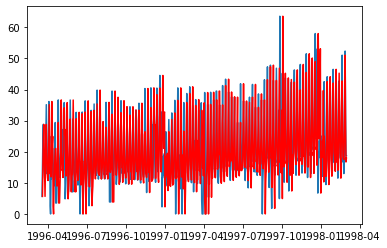

In [36]:
fit_mean_df = pd.DataFrame(fit_mean, index = series_train.index[1:])
fit_naive_df = pd.DataFrame(fit_naive, index = series_train.index[1:])
fit_snaive_df = pd.DataFrame(fit_snaive, index = series_train.index[1:])

plt.figure()
plt.plot(series_train)
plt.plot(fit_mean_df, color='orange')

plt.figure()
plt.plot(series_train)
plt.plot(fit_naive_df, color='green')

plt.figure()
plt.plot(series_train)
plt.plot(fit_snaive_df, color='red')

* Implement a new forecasting method which computes the forecast for $y_{t}$ by taking the average of $y_{t-1}, y_{t-7}, y_{t-14}$.
For the first two weeks, you can use the seasonal naive forecasts.


In [37]:
# 
fit_snaive2 = [(series_train[i-1] + series_train[i-7] + series_train[i-14])/3 for i in range(14, len(series_train)) ]
fit_snaive2 = fit_snaive[:13] + fit_snaive2
resid_snaive2 = series_train.values[1:] - fit_snaive2



Compare this new method with the seasonal naive method (e.g. histogram of residuals and ACF plot).

resid_snaive     58.154758
resid_snaiv2e    44.448970
dtype: float64


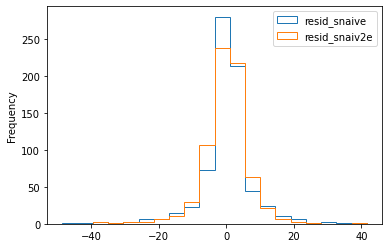

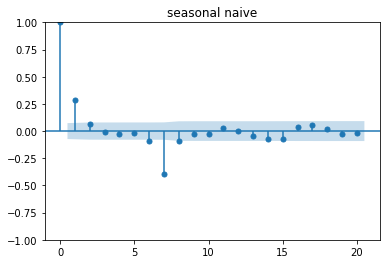

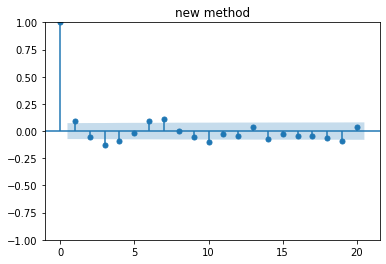

In [38]:
#
resid = pd.DataFrame({'resid_snaive': resid_snaive, 'resid_snaiv2e': resid_snaive2})
resid.plot.hist( bins = 20, histtype = "step")

plot_acf(resid_snaive, lags= 20, alpha=0.05, title = "seasonal naive")
plot_acf(resid_snaive2, lags= 20, alpha=0.05, title = "new method")

print( (resid**2).mean() )



* Compute $21$-step ahead out-of-sample forecasts for the different methods.
* Plot the forecasts and the true values.

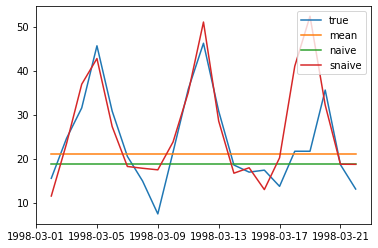

In [39]:
# Out-of-sample forecasts

period = 7
T = len(series_train)
HORIZON = n_test

## Mean
meanf = series_train.mean()
f_mean = pd.DataFrame([meanf for h in range(0, HORIZON) ], index = series_test.index)

## Naive
f_naive = series_train[-1]
f_naive = pd.DataFrame([f_naive for h in range(0, HORIZON) ], index = series_test.index)


## Seasonal naive
#f_snaive = [series_train[T + h - period * ((HORIZON -1)//period + 1)] for h in range(0, HORIZON) ]
f_snaive = [series_train[-HORIZON+h] for h in range(0, HORIZON) ]
f_snaive = pd.DataFrame(f_snaive, index = series_test.index)

plt.plot(series_test, label='true')
plt.plot(f_mean, label='mean')
plt.plot(f_naive, label='naive')
plt.plot(f_snaive, label='snaive')
plt.legend(loc='upper right')

